In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.preprocessing import LabelBinarizer
from skimage.restoration import *
from skimage import data, img_as_float
import cv2

import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

%matplotlib inline
import os
from sklearn.utils import shuffle
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu


In [3]:
train = np.load("./train_images.npy", encoding = 'bytes')
test = np.load("./test_images.npy", encoding = 'bytes')
train_labels = pd.read_csv("./train_labels.csv")

x_train = train[:,1]
x_test = test[:,1]
x_train /= 255
x_test /= 255

train_labs = pd.factorize(train_labels['Category'])
train_lab = train_labs[0]

x_train = np.array([np.array(x) for x in x_train])
x_test = np.array([np.array(x) for x in x_test])

x_train = x_train.reshape((10000,100,100))
x_test = x_test.reshape((10000,100,100))

lb = LabelBinarizer()
y_train = lb.fit_transform(train_lab)
x_train,y_train = shuffle(x_train,y_train, random_state = 0)

train_X = x_train[:8000]
train_y = y_train[:8000]
test_X = x_train[8000:]
test_y = y_train[8000:]
IMAGE_SIZE = 100
print(train_X.shape,test_X.shape,test_y.shape)

z = train_labels.drop_duplicates('Category')
z= z.reset_index()
z = z['Category']
label_dict = z.to_dict()

(8000, 100, 100) (2000, 100, 100) (2000, 31)


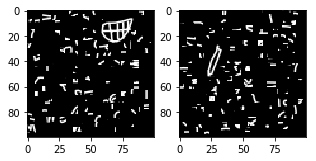

In [4]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[0], (100,100))
curr_lbl = np.argmax(y_train[0])
plt.imshow(curr_img, cmap='gray')
# plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_X[0], (100,100))
curr_lbl = np.argmax(y_train[0])
plt.imshow(curr_img, cmap='gray')
# plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [14]:
def denoise(noisy,s1,s2,s3,s4):
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (s1,s1))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (s2,s2))
    se3 = cv2.getStructuringElement(cv2.MORPH_RECT, (s3,s3))
    se4 = cv2.getStructuringElement(cv2.MORPH_RECT, (s4,s4))
    mask = cv2.morphologyEx(noisy, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se4)

    out = (noisy * mask)/255
    return out


def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = (-25,25)
    return sk.transform.rotate(image_array, random_degree, preserve_range=True).astype(np.uint8)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]


In [ ]:
plt.subplot(121)
curr_img = np.reshape(test_X[0], (100,100))
curr_lbl = np.argmax(y_train[0])
plt.imshow(curr_img, cmap='gray')
plt.subplot(122)

plt.imshow(denoise(test_X[1],8,4,4,1), cmap='gray')

In [ ]:
tr1_X = train_X.copy()
te1_X = test_X.copy()
tr2_X = train_X.copy()
te2_X = test_X.copy()
for i in tqdm(range(len(train_X)),desc='denoising train'):
    tr1_X[i] = denoise(tr1_X[i],7,5,5,1)
for i in tqdm(range(len(test_X)),desc='denoising test'):
    te1_X[i] = denoise(te1_X[i],7,5,5,1)

for i in tqdm(range(len(train_X)),desc='denoising train'):
    tr2_X[i] = denoise(tr2_X[i],5,5,5,1)
for i in tqdm(range(len(test_X)),desc='denoising test'):
    te2_X[i] = denoise(te2_X[i],5,5,5,1)


In [15]:
# tr_randrot = random_rotation(train_X)
tr_hor_flip = horizontal_flip(train_X)
# te_randrot = random_rotation(train_X)
# te_hor_flip = horizontal_flip(test_X)

train_X = np.row_stack((train_X,tr_hor_flip))
# test_X = np.row_stack((test_X,te_X,te_randrot,te_hor_flip))
train_y = np.row_stack((train_y,train_y))
# test_y = np.row_stack((test_y))

In [ ]:
plt.imshow(tr_randrot[1], cmap='gray')

In [16]:
train_X, train_y = shuffle(train_X,train_y, random_state = 0)

In [ ]:
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (?, IMAGE_SIZE, IMAGE_SIZE, 1))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data
	
# Produce each image at scaling of 90%, 75% and 60% of original image.
scaled_imgs = central_scale_images(train_X, [0.90, 0.75, 0.60])

In [ ]:
curr_img = np.reshape(train_X[0], (100,100))
plt.imshow(curr_img)

In [6]:
# Reshape training and testing image
train_X = train_X.reshape(-1, 100, 100, 1)
test_X = test_X.reshape(-1,100,100,1)
print(train_X.shape,test_X.shape)

(8000, 100, 100, 1) (2000, 100, 100, 1)


In [ ]:
def images_preprocessing(images):
    list_hog_fd = []
    for feature in tqdm(images):
            fd = hog(feature, orientations=196, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
            list_hog_fd.append(fd)
    return np.array(list_hog_fd, 'float64')

In [7]:
training_iters = 200 
learning_rate = 0.01 
batch_size = 128

# MNIST data input (img shape: 28*28)
n_input = 100

# MNIST total classes (0-9 digits)
n_classes = 31

In [8]:
#both placeholders are of type float
x = tf.placeholder("float", [None, 100,100,1])
y = tf.placeholder("float", [None, n_classes])

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')


In [9]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,16), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,16,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
#     'wc4': tf.get_variable('W3', shape=(3,3,128,256), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W4', shape=(13*13*64,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(64,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
#     'bc4': tf.get_variable('B3', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B4', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B5', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer()),
}

In [10]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    print(conv1)
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)
    print(conv1)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    print(conv2)
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)
    print(conv2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    print(conv3)

    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)
    print(conv3)
    
#     conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
#     print(conv4)

#     # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
#     conv4 = maxpool2d(conv4, k=2)
#     print(conv4)
    
    


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    print(fc1)

    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(out)
    drop = tf.layers.dropout(inputs=out, rate=0.4)
    print(drop)

    return drop

In [11]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Tensor("Relu:0", shape=(?, 100, 100, 16), dtype=float32)
Tensor("MaxPool:0", shape=(?, 50, 50, 16), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50, 50, 32), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 25, 25, 32), dtype=float32)
Tensor("Relu_2:0", shape=(?, 25, 25, 64), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 13, 13, 64), dtype=float32)
Tensor("Reshape:0", shape=(?, 10816), dtype=float32)
Tensor("Add_1:0", shape=(?, 31), dtype=float32)
Tensor("dropout/Identity:0", shape=(?, 31), dtype=float32)


In [12]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
#         train_X, train_y = shuffle(train_X,train_y, random_state = 0)
        for batch in tqdm(range(len(train_X)//batch_size)):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]   
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

100%|██████████| 125/125 [03:15<00:00,  1.38s/it]


Iter 0, Loss= 3.358326, Training Accuracy= 0.06250
Optimization Finished!


  0%|          | 0/125 [00:00<?, ?it/s]

Testing Accuracy: 0.06000


100%|██████████| 125/125 [02:52<00:00,  1.36s/it]


Iter 1, Loss= 3.357289, Training Accuracy= 0.06250
Optimization Finished!


  0%|          | 0/125 [00:00<?, ?it/s]

Testing Accuracy: 0.06000


100%|██████████| 125/125 [02:51<00:00,  1.71s/it]


Iter 2, Loss= 3.356713, Training Accuracy= 0.06250
Optimization Finished!


  0%|          | 0/125 [00:00<?, ?it/s]

Testing Accuracy: 0.06000


100%|██████████| 125/125 [03:58<00:00,  2.19s/it]


Iter 3, Loss= 3.356353, Training Accuracy= 0.06250
Optimization Finished!


  0%|          | 0/125 [00:00<?, ?it/s]

Testing Accuracy: 0.06000


100%|██████████| 125/125 [04:49<00:00,  4.14s/it]


Iter 4, Loss= 3.356038, Training Accuracy= 0.06250
Optimization Finished!


In [ ]:
# Build the model
def autoencoder(inputs):

    # Encode
    x =  tf.nn.conv2d(inputs, padding='SAME')
    x = tf.nn.relu(alpha=0.02,x)
    x = maxpool2d(x)
    
#    x = Conv2D(16, 5, padding='same')(x)
#    x = LeakyReLU(alpha=0.02)(x)
#    x = MaxPooling2D(padding='same')(x)
    
    x = Conv2D(8, 5, padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    encoded = MaxPooling2D(padding='same')(x)    
    
    # Decode
    x = Conv2D(8, 5, padding='same')(encoded)
    x = LeakyReLU(alpha=0.02)(x)
    x = UpSampling2D()(x)
    
#    x = Conv2D(16, 5, padding='same')(x)
#    x = LeakyReLU(alpha=0.02)(x)
#    x = UpSampling2D()(x)
    
    x = Conv2D(32, 5, padding='same')(x) 
    x = LeakyReLU(alpha=0.02)(x)
    x = UpSampling2D()(x)
    
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    # Autoencoder
    autoencoder = Model(inputs, decoded)
    
    # Compile
    autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')
    
    return autoencoder